In [1]:
import os
import sys
import numpy as np
import pandas as pd
import torch
# from pyod.models.iforest import IForest
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import auc

In [2]:
fold_num = 4

In [5]:
prefix = '' 

# change to your corresponding dir
y_train_pred = np.load(f'../AE_and_SVDD/traditional_save/{prefix}_auto_encoder_use_ind_only_fold%d_y_train_pred.npy' % fold_num)
y_train_scores = np.load(f'../AE_and_SVDD/traditional_save/{prefix}_auto_encoder_use_ind_only_fold%d_y_train_scores.npy' % fold_num)
y_test_pred = np.load(f'../AE_and_SVDD/traditional_save/{prefix}_auto_encoder_use_ind_only_fold%d_y_test_pred.npy' % fold_num)
y_test_scores = np.load(f'../AE_and_SVDD/traditional_save/{prefix}_auto_encoder_use_ind_only_fold%d_y_test_scores.npy' % fold_num)
y_test = np.load(f'../AE_and_SVDD/traditional_save/{prefix}_auto_encoder_use_ind_only_fold%d_y_test.npy' % fold_num)

print(y_train_pred.shape, y_train_scores.shape, y_test_pred.shape, y_test_scores.shape, y_test.shape)

(447685,) (447685,) (240870,) (240870,) (240870, 1)


In [7]:
# replace the following two car number lists
ind_ood_car_dict = np.load('../five_fold_utils/ind_odd_dict1.npz.npy', allow_pickle=True).item()
ind_car_num_list = ind_ood_car_dict['ind_sorted']
ood_car_num_list = ind_ood_car_dict['ood_sorted']

car_number_train = ind_car_num_list[:int(fold_num * len(ind_car_num_list) / 5)] + ind_car_num_list[int((fold_num + 1) * len(ind_car_num_list) / 5):]
car_number_test = ind_car_num_list[int(fold_num * len(ind_car_num_list) / 5):int((fold_num + 1) * len(ind_car_num_list) / 5)] + ood_car_num_list

# build 3 column csv file
all_car_dict = np.load('../five_fold_utils/all_car_dict.npz.npy', allow_pickle=True).item()

car_train = []
for each_num in car_number_train:
    for each_pkl in all_car_dict[each_num]:
        car_train.append(each_num)
car_test = []
for each_num in car_number_test:
    for each_pkl in all_car_dict[each_num]:
        car_test.append(each_num)
print(len(car_train))
print(len(car_test))
car_train = np.array(car_train)
car_test = np.array(car_test)

car_label_train = []
car_label_test = []

for each in car_train:
    if each in ind_car_num_list:
        car_label_train.append(0)
    if each in ood_car_num_list:
        car_label_train.append(1)
for each in car_test:
    if each in ind_car_num_list:
        car_label_test.append(0)
    if each in ood_car_num_list:
        car_label_test.append(1)
car_label_train = np.array(car_label_train)
car_label_test = np.array(car_label_test)

data_train = np.vstack((car_label_train, car_train, y_train_scores)).T
data_test = np.vstack((car_label_test, car_test, y_test_scores)).T

data = np.vstack((data_train, data_test))
print(data[0:5])

447685
240870
[[  0.           2.          62.69390045]
 [  0.           2.         196.1393564 ]
 [  0.           2.         110.06274975]
 [  0.           2.         246.94261561]
 [  0.           2.         265.61260239]]


In [8]:
validation_car_number = ind_car_num_list[:int(fold_num * len(ind_car_num_list) / 5)] + ind_car_num_list[int((fold_num + 1) * len(ind_car_num_list) / 5):] + ood_car_num_list[int(fold_num * len(ood_car_num_list) / 5):int((fold_num + 1) * len(ood_car_num_list) / 5)]
test_car_number = ind_car_num_list[int(fold_num * len(ind_car_num_list) / 5):int((fold_num + 1) * len(ind_car_num_list) / 5)] + ood_car_num_list[:int(fold_num * len(ood_car_num_list) / 5)] + ood_car_num_list[int((fold_num + 1) * len(ood_car_num_list) / 5):]
# test_car_number = ind_car_num_list[int(fold_num * len(ind_car_num_list) / 5):int((fold_num + 1) * len(ind_car_num_list) / 5)] + ood_car_num_list

In [9]:
ind_car_score = []
ood_car_score = []

for each_car_num in test_car_number:
    this_car_score = np.mean(data[np.where(data[:, 1]==each_car_num)][:, 2])
    if each_car_num in ind_car_num_list:
        ind_car_score.append(this_car_score)
    else:
        ood_car_score.append(this_car_score)
#     print(each_car_num, len(this_car_score))

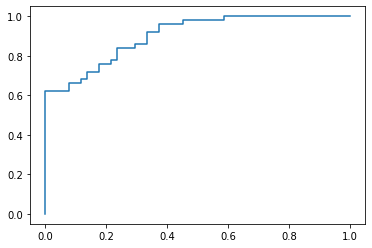

0.9019607843137254


In [11]:
label = [1] * len(ood_car_score) + [0] * len(ind_car_score)
score = np.hstack((ood_car_score, ind_car_score))

fpr, tpr, thresholds = metrics.roc_curve(label, score, pos_label=1)
plt.plot(fpr, tpr)
plt.show()
AUC = auc(fpr, tpr)
print(AUC)

np.save('../AE_and_SVDD/traditional_save/average_all_score_fold%d.npy' % fold_num, score)
np.save('../AE_and_SVDD/traditional_save/average_labels_fold%d.npy' % fold_num, label)